# Linking Writing Processes to Writing Quality

## Library

In [1]:
import os
import gc
import random
from glob import glob
from pathlib import Path
from collections import Counter, defaultdict
import re
import copy

import numpy as np
import pandas as pd
import torch
from scipy.stats import skew, kurtosis

from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GroupKFold
from sklearn.metrics import mean_absolute_error, mean_squared_error

# model
import optuna
import lightgbm as lgb
import xgboost as xgb
from catboost import Pool, CatBoostRegressor, CatBoostClassifier
from sklearn.ensemble import HistGradientBoostingRegressor

In [2]:
# /kaggle/working配下にディレクトリを作成
!mkdir models
!mkdir oof

## Configurations

In [3]:
class Config:
    VERSION = 1
    COMPETITION = "linking-writing-processes-to-writing-quality"
    DATA_PATH = os.path.join("/", "kaggle", "input", COMPETITION)
    OOF_DATA_PATH = Path("./oof")
    MODEL_DATA_PATH = Path("./models")
    
    USES_GPU = False
    
    seed = 42
    
    """
    > Optuna options
    """
    USES_OPTUNA_TUNING = False
    
    test_size_optuna = 0.2
    num_trials_optuna = 80
    num_trials_early_stopping = 40
    
    """
    > Modeling options
    """
    target_col = "score"
    metric = "rmse"
    
    num_boost_rounds = 50500
    early_stopping_round = 250
    verbose = 100
    
    num_folds = 10
    
    if USES_GPU:
        regression_lgb_params["device"] = "gpu"
        regression_xgb_params["tree_method"] = "gpu_hist"
        regression_xgb_params["predictor"] = "gpu_predictor"
        regression_cat_params["task_type"] = "GPU"

### Set seed

In [4]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    # CUDAのseedを発生するためにtorchを使用
    torch.manual_seed(seed)
    if Config.USES_GPU:
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        
seed_everything(Config.seed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cpu


## Load data

In [5]:
train_df = pd.read_csv(os.path.join(Config.DATA_PATH, "train_logs.csv"))
scores_df = pd.read_csv(os.path.join(Config.DATA_PATH, "train_scores.csv"))

test_df = pd.read_csv(os.path.join(Config.DATA_PATH, "test_logs.csv"))

In [6]:
train_df

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count
0,001519c8,1,4526,4557,31,Nonproduction,Leftclick,Leftclick,NoChange,0,0
1,001519c8,2,4558,4962,404,Nonproduction,Leftclick,Leftclick,NoChange,0,0
2,001519c8,3,106571,106571,0,Nonproduction,Shift,Shift,NoChange,0,0
3,001519c8,4,106686,106777,91,Input,q,q,q,1,1
4,001519c8,5,107196,107323,127,Input,q,q,q,2,1
...,...,...,...,...,...,...,...,...,...,...,...
8405893,fff05981,3615,2063944,2064440,496,Nonproduction,Leftclick,Leftclick,NoChange,1031,240
8405894,fff05981,3616,2064497,2064497,0,Nonproduction,Shift,Shift,NoChange,1031,240
8405895,fff05981,3617,2064657,2064765,108,Replace,q,q,q => q,1031,240
8405896,fff05981,3618,2069186,2069259,73,Nonproduction,Leftclick,Leftclick,NoChange,1028,240


In [7]:
scores_df

,id,score
0,001519c8,3.5
1,0022f953,3.5
2,0042269b,6.0
3,0059420b,2.0
4,0075873a,4.0
...,...,...
2466,ffb8c745,3.5
2467,ffbef7e5,4.0
2468,ffccd6fd,1.5
2469,ffec5b38,5.0


## Feature engineering

### Essay Constructor

- MASKされてバラバラになったエッセイを再構築する！
- https://www.kaggle.com/code/yuriao/fast-essay-constructor

In [8]:
class EssayConstructor:
    def get_essays(self, df):
        # 必要なカラムのみ抽出
        text_input_df = copy.deepcopy(
            df[["id", "activity", "cursor_position", "text_change"]]
        )
        text_input_df = text_input_df[text_input_df.activity != "Nonproduction"] # Nonproductionの除外
        
        tqdm.pandas()
        essay = text_input_df.groupby("id")[
            ["activity", "cursor_position", "text_change"]
        ].progress_apply(lambda v: self._process_inputs(v))
        
        essay_df = essay.to_frame().reset_index()
        essay_df.columns = ["id", "essay"]
        
        return essay_df
        
    def _process_inputs(self, currTextInput):
        """データのテキスト入力イベントの値からエッセイを復元
        
        Args:
            currTextInput: train_logsからinput系のカラムを抽出したもの
                ["activity", "cursor_position", "text_change", "id"]
        """
        # Where the essay content will be stored
        essayText = ""
        
        # Produces the essay
        for Input in currTextInput.values:
            activity = Input[0]
            
            if activity == 'Replace':
                # splits text_change at ' => '
                replaceTxt = Input[2].split(' => ')
                # DONT TOUCH
                essayText = essayText[:Input[1] - len(replaceTxt[1])] + replaceTxt[1] + essayText[Input[1] - len(replaceTxt[1]) + len(replaceTxt[0]):]
                
            elif activity == 'Paste':
                # DONT TOUCH
                essayText = essayText[:Input[1] - len(Input[2])] + Input[2] + essayText[Input[1] - len(Input[2]):]
                
            elif activity == 'Remove/Cut':
                # DONT TOUCH
                essayText = essayText[:Input[1]] + essayText[Input[1] + len(Input[2]):]
                
            elif "M" in activity:
                # Gets rid of the "Move from to" text
                croppedTxt = activity[10:]              
                # Splits cropped text by ' To '
                splitTxt = croppedTxt.split(' To ')              
                # Splits split text again by ', ' for each item
                valueArr = [item.split(', ') for item in splitTxt]              
                # Move from [2, 4] To [5, 7] = (2, 4, 5, 7)
                moveData = (int(valueArr[0][0][1:]), int(valueArr[0][1][:-1]), int(valueArr[1][0][1:]), int(valueArr[1][1][:-1]))
                # Skip if someone manages to activiate this by moving to same place
                if moveData[0] != moveData[2]:
                    # Check if they move text forward in essay (they are different)
                    if moveData[0] < moveData[2]:
                        # DONT TOUCH
                        essayText = essayText[:moveData[0]] + essayText[moveData[1]:moveData[3]] + essayText[moveData[0]:moveData[1]] + essayText[moveData[3]:]
                    else:
                        # DONT TOUCH
                        essayText = essayText[:moveData[2]] + essayText[moveData[0]:moveData[1]] + essayText[moveData[2]:moveData[0]] + essayText[moveData[1]:]
            
            else:
                # If activity = input
                # DONT TOUCH
                essayText = essayText[:Input[1] - len(Input[2])] + Input[2] + essayText[Input[1] - len(Input[2]):]
        
        return essayText

### Preprocessor

In [9]:
# # 最初に参考にしたtakaitoさんのPreprocessorコード

# class Preprocessor:
#     def __call__(self, X_df: pd.DataFrame, y_df: pd.DataFrame) -> pd.DataFrame:
#         df = pd.merge(
#             # idの最後の1行を指定することとでevent_idをイベント数、up_timeを総時間として扱える
#             X_df.groupby("id").tail(1),
#             y_df,
#             on="id",
#             how="left"
#         )
#         df = df.drop(
#             columns=[
#                 "down_time",
#                 "action_time",
#                 "activity",
#                 "down_event",
#                 "up_event",
#                 "text_change",
#                 "cursor_position",
#             ]
#         ).rename(
#             columns={
#                 "event_id": "total_event_count",
#                 "up_time": "total_time",
#             }
#         )
        
#         # プロシージャ
#         # ex1
#         df = self._create_written_word_pace(df)
        
#         # ex2
#         event_count_df = self._create_event_counts(X_df)
#         df = pd.merge(df, event_count_df, on="id", how="left")
        
#         # ex3
#         simple_activity_count_df = self._create_activity_total_counts(X_df)
#         df = pd.merge(df, simple_activity_count_df, on="id", how="left")

#         return df

#     def _create_written_word_pace(self, df: pd.DataFrame) -> pd.DataFrame:
#         """(ex1) How many words are written per minute(event)?
        
#         Args:
#             df (pd.DataFrame)
#         Returns:
#             df (pd.DataFrame)
#         """
#         # per minute
#         df["word/m"] = df["word_count"] / (df["total_time"] / 1000 / 60)
#         # per event
#         df["word/event"] = df["word_count"] / (df["total_event_count"])
        
#         return df

#     def _create_event_counts(self, X_df: pd.DataFrame) -> pd.DataFrame:
#         event_count_df = pd.crosstab(X_df["id"], X_df["event_id"])
#         event_count_df.columns = [
#             f"event_{col}_total_count" for col in event_count_df.columns
#         ]
        
#         event_count_df = event_count_df.reset_index()
        
#         return event_count_df
    
#     def _create_activity_total_counts(self, X_df: pd.DataFrame) -> pd.DataFrame:
#         """(ex2) Cross-tabulation of activity types
        
#         Args:
#             df (pd.DataFrame)
#         Returns:
#             df (pd.DataFrame)
#         """
#         # Move_Fromをシンプル(一意)に設定
#         X_df["simple_activity"] = np.where(
#             X_df["activity"].str[:9] == "Move From",
#             "Move_From_A_To_B",
#             X_df["activity"],
#         )
#         # id毎にカウントをとる
#         simple_activity_count_df = pd.crosstab(X_df["id"], X_df["simple_activity"])
#         simple_activity_count_df.columns = [
#             f"activity_{col}_total_count" for col in simple_activity_count_df.columns
#         ]

#         simple_activity_count_df = simple_activity_count_df.reset_index()
        
#         return simple_activity_count_df

In [10]:
# nth percentile function for agg
def percentile(n):
    def percentile_(x):
        return x.quantile(n/100)

    percentile_.__name__ = "pct_{:02.0f}".format(n)
    
    return percentile_

def q1(x):
    return x.quantile(0.25)

def q3(x):
    return x.quantile(0.75)

In [11]:
class Preprocessor:
    def __init__(self, seed):
        self.seed = seed
        
        self.activities = ["Input", "Remove/Cut", "Nonproduction", "Replace", "Paste"]
        self.events = [
            "q",
            "Space",
            "Backspace",
            "Shift",
            "ArrowRight",
            "Leftclick",
            "ArrowLeft",
            ".",
            ",",
            "ArrowDown",
            "ArrowUp",
            "Enter",
            "CapsLock",
            "'",
            "Delete",
            "Unidentified",
        ]
        self.text_changes_dict = {
            "q": "q",
            " ": "space",
            "NoChange": "NoChange",
            ".": "full_stop",
            ",": "comma",
            "\n": "newline",
            "'": "single_quote",
            '"': "double_quote",
            "-": "dash",
            "?": "question_mark",
            ";": "semicolon",
            "=": "equals",
            "/": "slash",
            "\\": "double_backslash",
            ":": "colon",
        }
        self.punctuations = ['"', ".", ",", '"', "-", ";", ":", "?", "!", "<", ">", "/", "@", "#", "$", "%", "^", "&", "*", "(", ")", "_", "+"]
        
        self.gaps = [1, 2, 3, 5, 10, 20, 50, 70, 100]
        self.percentiles = [5, 10, 25, 50, 75, 90, 95]
        self.percentiles_cols = [percentile(n) for n in self.percentiles]
        
        self.aggregations = [
            "mean",
            "std",
            "min",
            "max",
            "first",
            "last",
            "sem",
            q1,
            "median",
            q3,
            "skew",
            pd.DataFrame.kurt,
            "sum",
        ]
        
        self.idf = defaultdict(float)
        
        self.essay_constructor = EssayConstructor()
    
    def make_feats(self, df: pd.DataFrame, save_essays_path: str):
        """特徴量の作成
        
        Args:
            df (pd.DataFrame): 入力データ
        """
        print("Starting to engineer features")
        
        # initialize features dataframe
        feats = pd.DataFrame({"id": df["id"].unique().tolist()})
        
        # get essay feats
        print("Getting essays")
        essay_df = self.essay_constructor.get_essays(df)
        essay_df.to_csv(save_essays_path, index=False)
        
        print("Getting essay aggregations data")
        essay_agg_df = self.get_essay_aggregations(essay_df)
        feats = feats.merge(essay_agg_df, on="id", how="left")
        
        print("Getting essay word aggregations data")
        word_df = self.split_essays_into_words(essay_df)
        word_agg_df = self.compute_word_aggregations(word_df)
        feats = feats.merge(word_agg_df, on="id", how="left")
                
        print("Getting essay sentence aggregations data")
        sentence_df = self.split_essays_into_sentences(essay_df)
        sentence_agg_df = self.compute_sentence_aggregations(sentence_df)
        feats = feats.merge(sentence_agg_df, on="id", how="left")
        
        print("Getting essay paragraph aggregations data")
        paragraph_df = self.split_essays_into_paragraphs(essay_df)
        paragraph_agg_df = self.compute_paragraph_aggregations(paragraph_df)
        feats = feats.merge(paragraph_agg_df, on="id", how="left")
        
        # engineer counts data
        print("Engineering counts data")
        tmp_df = self.activity_counts(df=df)
        feats = pd.concat([feats, tmp_df], axis=1)
        
        tmp_df = self.event_counts(df=df, colname="down_event")
        feats = pd.concat([feats, tmp_df], axis=1)
        tmp_df = self.event_counts(df=df, colname="up_event")
        feats = pd.concat([feats, tmp_df], axis=1)
        
        tmp_df = self.text_change_counts(df=df)
        feats = pd.concat([feats, tmp_df], axis=1)
        
        tmp_df = self.count_punctuations(df=df, colname="down_event")
        feats = pd.concat([feats, tmp_df], axis=1)
        
        # space features
        print("Engineering space-related data")
        tmp_df = self.make_space_features(df)
        feats = feats.merge(tmp_df, on="id", how="left")
        
        # get shifted features
        # 特定の時間や行動間のギャップを計算
        # time shift
        print("Engineering time data")
    
        for gap in self.gaps:
            print(f"> for gap {gap}")
            df[f"up_time_shift{gap}"] = df.groupby("id")["up_time"].shift(gap)
            df[f"action_time_gap{gap}"] = df["down_time"] - df[f"up_time_shift{gap}"]
            
        df.drop(columns=[f"up_time_shift{gap}" for gap in self.gaps], inplace=True)
        
        # cursor position shift
        print("Engineering cursor position data - gaps")
        for gap in self.gaps:
            print(f"> for gap {gap}")
            df[f"cursor_position_shift{gap}"] = df.groupby("id")["cursor_position"].shift(gap)
            df[f"cursor_position_change{gap}"] = df["cursor_position"] - df[f"cursor_position_shift{gap}"]
            df[f"cursor_position_abs_change{gap}"] = np.abs(df[f"cursor_position_change{gap}"])
        
        df.drop(columns=[f"cursor_position_shift{gap}" for gap in self.gaps], inplace=True)
        
        # word count shift
        print("Engineering word count data - gaps")
        for gap in self.gaps:
            print(f"> for gap {gap}")
            df[f"word_count_shift{gap}"] = df.groupby("id")["word_count"].shift(gap)
            df[f"word_count_change{gap}"] = df["word_count"] - df[f"word_count_shift{gap}"]
            df[f"word_count_abs_change{gap}"] = np.abs(df[f"word_count_change{gap}"])
            
        df.drop(columns=[f"word_count_shift{gap}" for gap in self.gaps], inplace=True)
        
        # get aggregate statistical features
        print("Engineering statistical summaries for features")
        # [(特徴量の名前, [追加したい統計量])]
        feats_stat = [
            ("event_id", ["max"]),
            ("up_time", ["max"]),
            ("action_time", ["sum", "max", "mean", "std"]),
            ("activity", ["nunique"]),
            ("down_event", ["nunique"]),
            ("up_event", ["nunique"]),
            ("text_change", ["nunique"]),
            ("cursor_position", ["nunique", "max", "mean"]),
            ("word_count", ["nunique", "max", "mean"]),
        ]
    
        for gap in self.gaps:
            feats_stat.extend([
                (f"action_time_gap{gap}", ["max", "min", "mean", "std", "sum", skew, kurtosis]),
                (f"cursor_position_change{gap}", ["max", "mean", "std", "sum", skew, kurtosis]),
                (f"word_count_change{gap}", ["max", "mean", "std", "sum", skew, kurtosis]),
            ])
        
        pbar = tqdm(feats_stat)
        for item in pbar:
            colname, methods = item[0], item[1]
            for method in methods:
                pbar.set_postfix()
                if isinstance(method, str):
                    method_name = method
                else:
                    method_name = method.__name__
                
                pbar.set_postfix(column=colname, method=method_name)
                tmp_df = df.groupby(["id"]).agg({colname: method}).reset_index().rename(
                    columns={colname: f"{colname}_{method_name}"}
                )
                feats = feats.merge(tmp_df, on="id", how="left")
        
        # input words
        print("Engineering input word data")
        tmp_df = self.calc_input_words(df=df)
        feats = pd.merge(feats, tmp_df, on="id", how="left")
        
        # compare feats
        print("Engineering ratios data")
        feats["word_time_ratio"] = feats["word_count_max"] / feats["up_time_max"]
        feats["word_event_ratio"] = feats["word_count_max"] / feats["event_id_max"]
        feats["event_time_ratio"] = feats["event_id_max"] / feats["up_time_max"]
        feats["idle_time_ratio"] = feats["action_time_gap1_sum"] / feats["up_time_max"]
        
        return feats
    
    def get_essay_aggregations(self, essay_df):
        """エッセイの文字数をカウント"""
        cols_to_drop = ["essay"]
        # Total essay length
        essay_df["essay_len"] = essay_df["essay"].apply(lambda v: len(v))
        essay_df = essay_df.drop(columns=cols_to_drop)
        
        return essay_df
    
    def split_essays_into_words(self, essay_df):
        # 文章単位でsplitしたそれぞれをexplodeで連結
        essay_df["word"] = essay_df["essay"].apply(
            lambda v: re.split(" |\\n|\\.|\\?|\\!", v)
        )
        essay_df = essay_df.explode("word")
        
        # Word length (num of characters in word)
        essay_df["word_len"] = essay_df["word"].apply(lambda v: len(v))
        essay_df = essay_df[essay_df["word_len"] != 0]
        
        return essay_df
    
    def compute_word_aggregations(self, word_df):
        """様々な統計特徴量を生成"""
        word_agg_df = word_df[["id", "word_len"]].groupby(["id"]).agg(self.aggregations)
        word_agg_df.columns = ["_".join(v) for v in word_agg_df.columns]
        word_agg_df["id"] = word_agg_df.index
        
        # 長さが以下のリスト内の要素を超える単語数の計算
        for v in [5, 6, 7, 8, 9, 10, 11, 12]:
            word_agg_df[f"word_len_ge_{v}_count"] = (
                word_df[word_df["word_len"] >= v].groupby(["id"]).count().iloc[:, 0]
            )
            word_agg_df[f"word_len_ge_{v}_count"] = word_agg_df[f"word_len_ge_{v}_count"].fillna(0)
            
        word_agg_df = word_agg_df.reset_index(drop=True)

        return word_agg_df
    
    def split_essays_into_sentences(self, essay_df):
        essay_df["sentence"] = essay_df["essay"].apply(lambda v: re.split("\\.|\\?|\\!", v))
        essay_df = essay_df.explode("sentence")
        
        essay_df["sentence"] = essay_df["sentence"].apply(lambda v: v.replace("\n", "").strip())
        
        # 文章内の文字数
        essay_df["sentence_len"] = essay_df["sentence"].apply(lambda v: len(v))
        # 文章内の単語数
        essay_df["sentence_word_count"] = essay_df["sentence"].apply(lambda v: len(v.split(" ")))
        
        essay_df = essay_df[essay_df.sentence_len != 0].reset_index(drop=True)
        
        return essay_df
    
    def compute_sentence_aggregations(self, sentence_df):
        sentence_agg_df = sentence_df[
            ["id", "sentence_len", "sentence_word_count"]
        ].groupby(["id"]).agg(self.aggregations)
        
        sentence_agg_df.columns = ["_".join(v) for v in sentence_agg_df.columns]
        sentence_agg_df["id"] = sentence_agg_df.index
        
        # 長さが以下のリスト内の要素を超える文章数の計算
        for v in [50, 60, 75, 100]:
            sentence_agg_df[f"sentence_len_ge_{v}_count"] = (
                sentence_df[sentence_df["sentence_len"] >= v].groupby(["id"]).count().iloc[:, 0]
            )
            sentence_agg_df[f"sentence_len_ge_{v}_count"] = (
                sentence_agg_df[f"sentence_len_ge_{v}_count"].fillna(0)
            )
            
        sentence_agg_df = sentence_agg_df.reset_index(drop=True)
        
        return sentence_agg_df
    
    def split_essays_into_paragraphs(self, essay_df):
        essay_df["paragraph"] = essay_df["essay"].apply(lambda v: v.split("\n"))
        essay_df = essay_df.explode("paragraph")
        
        # 段落内の文字数
        essay_df["paragraph_len"] = essay_df["paragraph"].apply(lambda v: len(v))
        # 段落内の文章数
        essay_df["paragraph_sentence_count"] = essay_df["paragraph"].apply(lambda v: len(v.split("\\.|\\?|\\!")))
        # 段落内の単語数
        essay_df["paragraph_word_count"] = essay_df["paragraph"].apply(lambda v: len(v.split(' ')))
        
        essay_df = essay_df[essay_df.paragraph_len != 0].reset_index(drop=True)
        
        return essay_df
    
    def compute_paragraph_aggregations(self, paragraph_df):
        paragraph_agg_df = paragraph_df[
            ["id", "paragraph_len", "paragraph_sentence_count", "paragraph_word_count"]
        ].groupby("id").agg(self.aggregations)
        
        paragraph_agg_df.columns = ["_".join(v) for v in paragraph_agg_df.columns]
        paragraph_agg_df["id"] = paragraph_agg_df.index
        paragraph_agg_df = paragraph_agg_df.reset_index(drop=True)
        
        return paragraph_agg_df
    
    def activity_counts(self, df):
        tmp_df = df.groupby("id").agg({"activity": list}).reset_index()
        
        l = []
        for cols in tqdm(tmp_df["activity"].values):
            counter = list(Counter(cols).items())
            
            # 初期化
            d = {}
            for v in self.activities:
                d[v] = 0
                
            # "move from X to Y"も考慮する
            d["move_to"] = 0
            
            for v in counter:
                item, count = v[0], v[1]
                if item in d:
                    d[item] = count
                else:
                    d["move_to"] += count
                    
            l.append(d)
            
        count_df = pd.DataFrame(l)
        tfidf_df, normal_df = pd.DataFrame(l), pd.DataFrame(l)
        
        tfidf_cols = [f"activity_{v}_tfidf_count" for v in count_df.columns]
        normal_cols = [f"activity_{v}_normal_count" for v in count_df.columns]
        
        tfidf_df.columns = tfidf_cols
        normal_df.columns = normal_cols
        
        counts = tfidf_df.sum(1)
        for col in tfidf_cols:
            if col in self.idf.keys():
                idf =self.idf[col]
            else:
                idf = df.shape[0] / (tfidf_df[col].sum()+1)
                idf = np.log(idf)
                self.idf[col] = idf
                
            tfidf_df[col] = 1+np.log(tfidf_df[col] / counts)
            tfidf_df[col] *= idf
            
        agg_df = pd.concat([tfidf_df, normal_df], axis=1)
        
        return agg_df
    
    def event_counts(self, df, colname):
        tmp_df = df.groupby("id").agg({colname: list}).reset_index()
        l = []
        for cols in tqdm(tmp_df[colname].values):
            counter = list(Counter(cols).items())
            
            # 初期化
            d = {}
            for v in self.activities:
                d[v] = 0
                
            # "move from X to Y"も考慮する
            d["move_to"] = 0
            
            for v in counter:
                item, count = v[0], v[1]
                if item in d:
                    d[item] = count
                    
            l.append(d)
            
        count_df = pd.DataFrame(l)
        tfidf_df, normal_df = pd.DataFrame(l), pd.DataFrame(l)
        
        tfidf_cols = [f"{colname}_{v}_tfidf_count" for v in count_df.columns]
        normal_cols = [f"{colname}_{v}_normal_count" for v in count_df.columns]
        
        tfidf_df.columns = tfidf_cols
        normal_df.columns = normal_cols
        
        counts = tfidf_df.sum(1)
        for col in tfidf_cols:
            if col in self.idf.keys():
                idf =self.idf[col]
            else:
                idf = df.shape[0] / (tfidf_df[col].sum()+1)
                idf = np.log(idf)
                self.idf[col] = idf
                
            tfidf_df[col] = 1+np.log(tfidf_df[col] / counts)
            tfidf_df[col] *= idf
            
        agg_df = pd.concat([tfidf_df, normal_df], axis=1)
        
        return agg_df
    
    def text_change_counts(self, df):
        tmp_df = df.groupby("id").agg({"text_change": list}).reset_index()
        l = []
        for cols in tqdm(tmp_df["text_change"].values):
            counter = list(Counter(cols).items())
            
            # 初期化
            d = {}
            for k in self.text_changes_dict.keys():
                d[k] = 0
                
            for v in counter:
                item, count = v[0], v[1]
                if item in d:
                    d[item] = count
                    
            l.append(d)
            
        count_df = pd.DataFrame(l)
        tfidf_df, normal_df = pd.DataFrame(l), pd.DataFrame(l)
        
        tfidf_cols = [f"text_change_{self.text_changes_dict[v]}_tfidf_count" for v in count_df.columns]
        normal_cols = [f"text_change_{self.text_changes_dict[v]}_normal_count" for v in count_df.columns]
        
        tfidf_df.columns = tfidf_cols
        normal_df.columns = normal_cols
        
        counts = tfidf_df.sum(1)
        for col in tfidf_cols:
            if col in self.idf.keys():
                idf =self.idf[col]
            else:
                idf = df.shape[0] / (tfidf_df[col].sum()+1)
                idf = np.log(idf)
                self.idf[col] = idf
                
            tfidf_df[col] = 1+np.log(tfidf_df[col] / counts)
            tfidf_df[col] *= idf
            
        agg_df = pd.concat([tfidf_df, normal_df], axis=1)
        
        return agg_df
    
    def count_punctuations(self, df: pd.DataFrame, colname: str) -> pd.DataFrame:
        grouped_df = df.groupby("id").agg({colname: list}).reset_index()
            
        l = []
        for cols in tqdm(grouped_df[colname].values):
            c = 0
            counter = list(Counter(cols).items())
            for v in counter:
                item, count = v[0], v[1]
                if item in self.punctuations:
                    c += count
            l.append(c)
            
        count_df = pd.DataFrame({"punct_count": l})
        
        return count_df
    
    def make_space_features(self, df):
        """
        @ref: https://www.kaggle.com/code/abdullahmeda/enter-ing-the-timeseries-space-sec-3-new-aggs/notebook
        """
        df["up_time_lagged"] = df.groupby("id")["up_time"].shift(1).fillna(df["down_time"])
        df["time_diff"] = abs(df["down_time"] - df["up_time_lagged"]) / 1000
        
        group = df.groupby("id")["time_diff"]
        largest_latency = group.max()
        smallest_latency = group.min()
        median_latency = group.median()
        
        initial_pause = df.groupby("id")["down_time"].first() / 1000
        
        pause_half_sec = group.apply(lambda v: ((v > 0.5)&(v < 1)).sum())
        pause_1_sec = group.apply(lambda v: ((v > 1)&(v < 1.5)).sum())
        pause_1_half_sec = group.apply(lambda v: ((v > 1.5)&(v < 2)).sum())
        pause_2_sec = group.apply(lambda v: ((v > 2)&(v < 3)).sum())
        pause_3_sec = group.apply(lambda v: ((v > 3).sum()))
        
        pause_df = pd.DataFrame({
            "id": df["id"].unique(),
            "largest_latency": largest_latency,
            "smallest_latency": smallest_latency,
            "median_latency": median_latency,
            "initial_pause": initial_pause,
            "pause_half_sec": pause_half_sec,
            "pause_1_sec": pause_1_sec,
            "pause_1_half_sec": pause_1_half_sec,
            "pause_2_sec": pause_2_sec,
            "pause_3_sec": pause_3_sec,
        }).reset_index(drop=True)
        
        return pause_df
        
        
    def calc_input_words(self, df: pd.DataFrame) -> pd.DataFrame:
        tmp_df = df[
            (~df["text_change"].str.contains("=>")) & (df["text_change"] != "NoChange")
        ].reset_index(drop=True)
        
        tmp_df = tmp_df.groupby("id").agg({"text_change": list}).reset_index()
        
        # 整形
        tmp_df["text_change"] = tmp_df["text_change"].apply(lambda x: "".join(x))
        tmp_df["text_change"] = tmp_df["text_change"].apply(lambda x: re.findall(r"q+", x))
        
        # 統計量の算出
        tmp_df["input_word_count"] = tmp_df["text_change"].apply(len)
        tmp_df["input_word_len_mean"] = tmp_df["text_change"].apply(
            lambda x: np.mean([len(i) for i in x] if len(x) > 0 else 0)
        )
        tmp_df["input_word_len_max"] = tmp_df["text_change"].apply(
            lambda x: np.max([len(i) for i in x] if len(x) > 0 else 0)
        )
        tmp_df["input_word_len_std"] = tmp_df["text_change"].apply(
            lambda x: np.std([len(i) for i in x] if len(x) > 0 else 0)
        )
        
        tmp_df.drop(["text_change"], axis=1, inplace=True)
        
        return tmp_df

In [12]:
preprocessor = Preprocessor(seed=Config.seed)

processed_train_df = preprocessor.make_feats(train_df, save_essays_path="train_essays.csv")
processed_test_df = preprocessor.make_feats(test_df, save_essays_path="test_essays.csv")

Starting to engineer features
Getting essays


  0%|          | 0/2471 [00:00<?, ?it/s]

Getting essay aggregations data
Getting essay word aggregations data
Getting essay sentence aggregations data
Getting essay paragraph aggregations data
Engineering counts data


  0%|          | 0/2471 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


  0%|          | 0/2471 [00:00<?, ?it/s]

  0%|          | 0/2471 [00:00<?, ?it/s]

  0%|          | 0/2471 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


  0%|          | 0/2471 [00:00<?, ?it/s]

Engineering space-related data
Engineering time data
> for gap 1
> for gap 2
> for gap 3
> for gap 5
> for gap 10
> for gap 20
> for gap 50
> for gap 70
> for gap 100
Engineering cursor position data - gaps
> for gap 1
> for gap 2
> for gap 3
> for gap 5
> for gap 10
> for gap 20
> for gap 50
> for gap 70
> for gap 100
Engineering word count data - gaps
> for gap 1
> for gap 2
> for gap 3
> for gap 5
> for gap 10
> for gap 20
> for gap 50
> for gap 70
> for gap 100
Engineering statistical summaries for features


  0%|          | 0/36 [00:00<?, ?it/s]

Engineering input word data
Engineering ratios data
Starting to engineer features
Getting essays


/tmp/ipykernel_19/3096739777.py:200: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feats["word_time_ratio"] = feats["word_count_max"] / feats["up_time_max"]
/tmp/ipykernel_19/3096739777.py:201: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feats["word_event_ratio"] = feats["word_count_max"] / feats["event_id_max"]
/tmp/ipykernel_19/3096739777.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at on

  0%|          | 0/3 [00:00<?, ?it/s]

Getting essay aggregations data
Getting essay word aggregations data
Getting essay sentence aggregations data
Getting essay paragraph aggregations data
Engineering counts data


  0%|          | 0/3 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


  0%|          | 0/3 [00:00<?, ?it/s]

Engineering space-related data
Engineering time data
> for gap 1
> for gap 2
> for gap 3
> for gap 5
> for gap 10
> for gap 20
> for gap 50
> for gap 70
> for gap 100
Engineering cursor position data - gaps
> for gap 1
> for gap 2
> for gap 3
> for gap 5
> for gap 10
> for gap 20
> for gap 50
> for gap 70
> for gap 100
Engineering word count data - gaps
> for gap 1
> for gap 2
> for gap 3
> for gap 5
> for gap 10
> for gap 20
> for gap 50
> for gap 70
> for gap 100
Engineering statistical summaries for features


  0%|          | 0/36 [00:00<?, ?it/s]

Engineering input word data
Engineering ratios data


/tmp/ipykernel_19/3096739777.py:200: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feats["word_time_ratio"] = feats["word_count_max"] / feats["up_time_max"]
/tmp/ipykernel_19/3096739777.py:201: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feats["word_event_ratio"] = feats["word_count_max"] / feats["event_id_max"]
/tmp/ipykernel_19/3096739777.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at on

In [13]:
processed_train_df = processed_train_df.merge(scores_df, on="id", how="left")

In [14]:
processed_train_df.head()

,id,essay_len,word_len_mean,word_len_std,word_len_min,word_len_max,word_len_first,word_len_last,word_len_sem,word_len_q1,...,word_count_change100_kurtosis,input_word_count,input_word_len_mean,input_word_len_max,input_word_len_std,word_time_ratio,word_event_ratio,event_time_ratio,idle_time_ratio,score
0,001519c8,1528,4.859375,2.515004,1,11,9,9,0.157188,3.0,...,NaN,366,5.325137,20,3.487804,0.000142,0.100117,0.001419,0.832534,3.5
1,0022f953,1675,4.040248,2.243332,1,15,4,3,0.124822,3.0,...,NaN,385,4.410390,33,3.199496,0.000181,0.131622,0.001372,0.828944,3.5
2,0042269b,2587,5.279412,2.798801,1,13,11,3,0.138561,3.0,...,NaN,627,5.446571,25,3.474895,0.000228,0.097679,0.002335,0.759751,6.0
3,0059420b,1154,4.490385,2.653938,1,13,2,8,0.184017,2.0,...,NaN,251,4.609562,19,2.949601,0.000147,0.132391,0.001108,0.835531,2.0
4,0075873a,1425,4.509804,2.495449,1,12,11,11,0.156271,3.0,...,NaN,412,4.766990,18,2.986064,0.000152,0.099565,0.001522,0.764103,4.0


## Check correlation coefficients

In [15]:
pd.set_option("display.max_rows", 400)
processed_train_df.drop(["id"], axis=1).corr().sort_values(["score"])["score"]

action_time_gap5_mean                       -0.606004
action_time_gap10_mean                      -0.602954
action_time_gap3_mean                       -0.600881
action_time_gap20_mean                      -0.596831
action_time_gap50_mean                      -0.585539
action_time_gap1_mean                       -0.585510
action_time_gap2_mean                       -0.584715
action_time_gap70_mean                      -0.579412
action_time_gap100_mean                     -0.572278
activity_move_to_tfidf_count                -0.485236
word_len_sem                                -0.484735
median_latency                              -0.470432
text_change_colon_tfidf_count               -0.467539
idle_time_ratio                             -0.448834
text_change_semicolon_tfidf_count           -0.385679
text_change_double_backslash_tfidf_count    -0.383606
text_change_slash_tfidf_count               -0.357980
activity_Paste_tfidf_count                  -0.357857
text_change_equals_tfidf_cou

## Split train data into folds for cross-validation

In [16]:
# TODO: StratifiedKFold(層化k分割交差検証)にしてみる
kfold = KFold(n_splits=Config.num_folds, shuffle=True, random_state=Config.seed)

for fold, (_, val_idx) in enumerate(kfold.split(processed_train_df)):
    processed_train_df.loc[val_idx, "fold"] = fold

/tmp/ipykernel_19/327259764.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  processed_train_df.loc[val_idx, "fold"] = fold


## Optimize Hyperparameters with Optuna

In [17]:
X = processed_train_df.drop(columns=["id", "fold", Config.target_col])
Y = processed_train_df[Config.target_col]

In [18]:
def objective(trial, data=X, target=Y):
    X_train, X_val, y_train, y_val = train_test_split(
        data,
        target,
        test_size=Config.test_size_optuna,
        random_state=Config.seed,
    )
    
    param = {
        'metric': Config.metric, 
        'random_state': Config.seed,
        'n_estimators': Config.num_boost_rounds // 100,
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'subsample': trial.suggest_float('subsample', 0.5, 1),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 0.1, log=True),
        'num_leaves' : trial.suggest_int('num_leaves', 8, 64),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 100),
    }
    
    model = lgb.LGBMRegressor(**param)
    
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_val, y_val)],
        early_stopping_rounds=Config.early_stopping_round,
        verbose=False,
    )
    
    preds = model.predict(X_val)
    
    rmse = mean_squared_error(y_val, preds, squared=False)
    
    return rmse

In [19]:
if Config.USES_OPTUNA_TUNING:
    study = optuna.create_study(direction="minimize", study_name="Optimize boosting hyperparameters")
    study.optimize(objective, n_trials=Config.num_trials_optuna)
    
    print('Best trial:', study.best_trial.params)

## Training

In [20]:
feature_names = list(
    filter(
        lambda x: x not in [Config.target_col, "id", "fold"], processed_train_df.columns
    )
)

if Config.USES_OPTUNA_TUNING:
    best_params = study.best_params
else:
    best_params ={'reg_alpha': 1.0522959856074883, 'reg_lambda': 0.00397056391661026, 'colsample_bytree': 0.792757666703387, 'subsample': 0.6559560851356916, 'learning_rate': 0.03549698302510524, 'num_leaves': 8, 'min_child_samples': 68}
    
lgbm_params = {
    "metric": Config.metric,
    "random_state": Config.seed,
    "n_estimators": Config.num_boost_rounds // 100,
    **best_params,
}

# [fold]: model
models_d = {}

for fold in range(Config.num_folds):
    print(f"Training for Fold {fold}")
    
    X_train = processed_train_df[processed_train_df["fold"] != fold][feature_names]
    y_train = processed_train_df[processed_train_df["fold"] != fold][Config.target_col]
    
    X_val = processed_train_df[processed_train_df["fold"] == fold][feature_names]
    y_val = processed_train_df[processed_train_df["fold"] == fold][Config.target_col]
    
    model = lgb.LGBMRegressor(**lgbm_params)
    
    model.fit(
        X_train,
        y_train,
        eval_names=["train", "valid"],
        eval_set=[(X_train, y_train), (X_val, y_val)],
        verbose=-1,
        eval_metric=Config.metric,
        early_stopping_rounds=Config.early_stopping_round,
    )
    
    # save
    models_d[fold] = model

Training for Fold 0


/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Training for Fold 1


/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Training for Fold 2


/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Training for Fold 3


/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Training for Fold 4


/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Training for Fold 5


/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Training for Fold 6


/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Training for Fold 7


/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Training for Fold 8


/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Training for Fold 9


/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


## Mean feature importance of LGBM models

In [21]:
feature_importance_values = np.asarray(
    [model.feature_importances_ for model in models_d.values()]
).mean(axis=0)

feature_importance_df = pd.DataFrame({
    "name": feature_names,
    "importance": feature_importance_values,
})

feature_importance_df = feature_importance_df.sort_values(
    "importance",
    ascending=False,
).head(50)

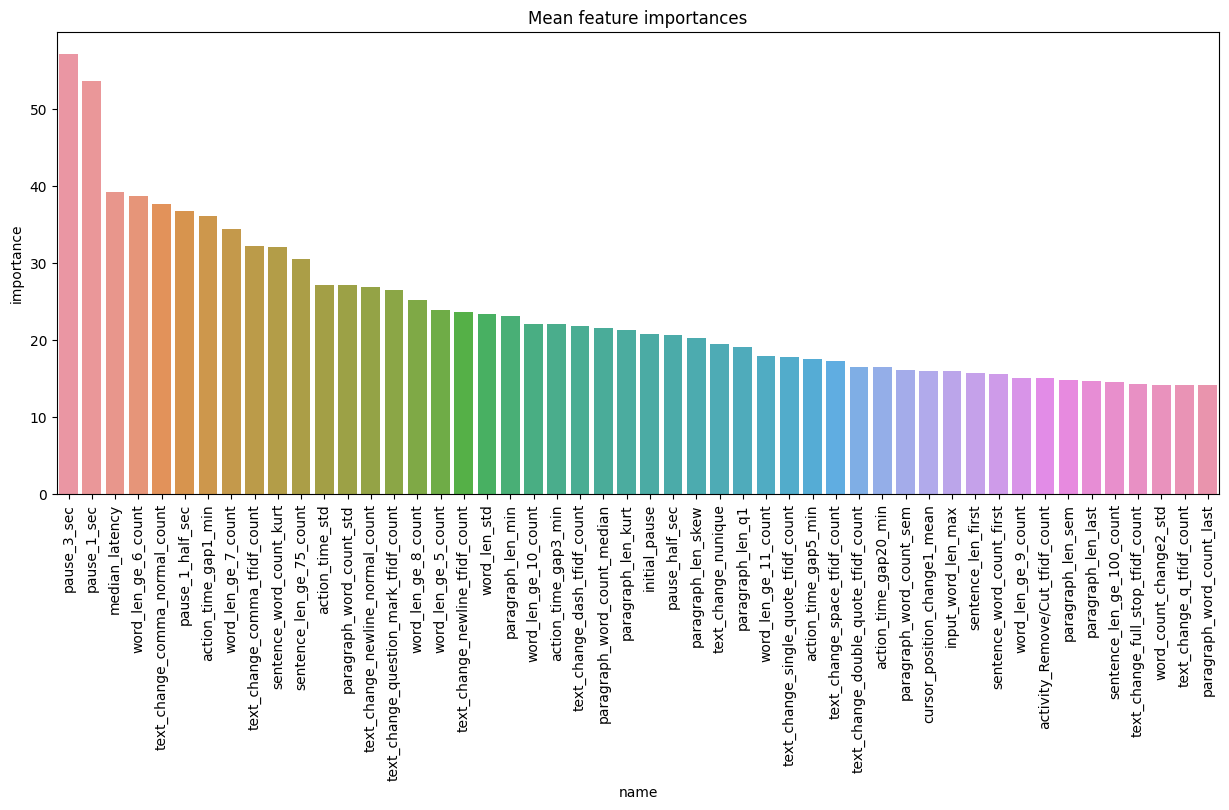

In [22]:
plt.figure(figsize=(15, 6))

ax = sns.barplot(
    data=feature_importance_df,
    x="name",
    y="importance",
)
ax.set_title(f"Mean feature importances")
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90)

plt.show()

## Evaluation of OOF preds on trianing set (CV)

In [23]:
# TODO: 学習時に一緒に計算する
# scores(list)にいれればできそう
for fold in range(Config.num_folds):
    print(f"Predicting the train set with fold{fold}")
    X_train = processed_train_df[processed_train_df["fold"] != fold][feature_names]
    y_train = processed_train_df[processed_train_df["fold"] != fold][Config.target_col]
    
    X_val = processed_train_df[processed_train_df["fold"] == fold][feature_names]
    y_val = processed_train_df[processed_train_df["fold"] == fold][Config.target_col]
    
    model = models_d[fold]
    pred = model.predict(
        X_val,
        num_iteration=model.best_iteration_,
    )
    
    processed_train_df.loc[X_val.index, f"pred_{Config.target_col}"] = pred

Predicting the train set with fold0
Predicting the train set with fold1
Predicting the train set with fold2
Predicting the train set with fold3


/tmp/ipykernel_19/2605761640.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  processed_train_df.loc[X_val.index, f"pred_{Config.target_col}"] = pred


Predicting the train set with fold4
Predicting the train set with fold5
Predicting the train set with fold6
Predicting the train set with fold7
Predicting the train set with fold8
Predicting the train set with fold9


In [24]:
rmse = mean_squared_error(
    processed_train_df[Config.target_col],
    np.clip(
        processed_train_df[f"pred_{Config.target_col}"],
        a_min=0.5,
        a_max=6.0,
    ),
    squared=False,         
)

print("CV RMSE: ", rmse)

CV RMSE:  0.6111310225954425


## Make submission

In [25]:
processed_train_df

,id,essay_len,word_len_mean,word_len_std,word_len_min,word_len_max,word_len_first,word_len_last,word_len_sem,word_len_q1,...,input_word_len_mean,input_word_len_max,input_word_len_std,word_time_ratio,word_event_ratio,event_time_ratio,idle_time_ratio,score,fold,pred_score
0,001519c8,1528,4.859375,2.515004,1,11,9,9,0.157188,3.00,...,5.325137,20,3.487804,0.000142,0.100117,0.001419,0.832534,3.5,7.0,3.542149
1,0022f953,1675,4.040248,2.243332,1,15,4,3,0.124822,3.00,...,4.410390,33,3.199496,0.000181,0.131622,0.001372,0.828944,3.5,9.0,3.519539
2,0042269b,2587,5.279412,2.798801,1,13,11,3,0.138561,3.00,...,5.446571,25,3.474895,0.000228,0.097679,0.002335,0.759751,6.0,4.0,4.698780
3,0059420b,1154,4.490385,2.653938,1,13,2,8,0.184017,2.00,...,4.609562,19,2.949601,0.000147,0.132391,0.001108,0.835531,2.0,6.0,2.470017
4,0075873a,1425,4.509804,2.495449,1,12,11,11,0.156271,3.00,...,4.766990,18,2.986064,0.000152,0.099565,0.001522,0.764103,4.0,8.0,3.380774
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2466,ffb8c745,1634,4.813187,2.625856,1,14,2,5,0.158924,3.00,...,4.915531,20,3.001989,0.000257,0.097278,0.002645,0.708572,3.5,5.0,3.775535
2467,ffbef7e5,2335,4.191874,2.217113,1,13,4,3,0.105338,3.00,...,4.085106,13,2.231589,0.000243,0.168203,0.001447,0.868855,4.0,7.0,3.934243
2468,ffccd6fd,2761,4.472906,2.454135,1,14,6,4,0.172246,3.00,...,4.644144,15,2.707087,0.000103,0.065622,0.001563,0.869824,1.5,0.0,1.961567
2469,ffec5b38,2552,5.045455,2.970735,1,24,10,7,0.145303,3.00,...,5.294000,24,3.541689,0.000274,0.127390,0.002149,0.794947,5.0,0.0,4.497859


In [26]:
for fold in range(Config.num_folds):
    print(f"Predict the test set with fold{fold}")
    X_test = processed_test_df[feature_names]
    
    model = models_d[fold]
    pred = model.predict(
        X_test,
        num_iteration=model.best_iteration_,
    )
    print(pred)
    
    processed_test_df[f"pred_{Config.target_col}_fold{fold}"] = pred
    
processed_test_df[Config.target_col] = processed_test_df[
    [f"pred_{Config.target_col}_fold{fold}" for fold in range(Config.num_folds)]
].mean(axis=1)

processed_test_df[Config.target_col] = np.clip(
    processed_test_df[Config.target_col],
    a_min=0.5,
    a_max=6.0,
)

Predict the test set with fold0
[1.42401851 1.27566668 1.37169633]
Predict the test set with fold1
[1.4021082  1.37357465 1.35953637]
Predict the test set with fold2
[1.46420238 1.35954629 1.42298991]
Predict the test set with fold3
[1.48988978 1.28536084 1.42962135]
Predict the test set with fold4
[1.38718165 1.34592549 1.37660955]
Predict the test set with fold5
[1.49901357 1.45817464 1.45817464]
Predict the test set with fold6
[1.61818005 1.52110842 1.57345961]
Predict the test set with fold7
[1.56916915 1.5276257  1.49062928]
Predict the test set with fold8
[1.45418063 1.48046508 1.52790675]
Predict the test set with fold9
[1.52543345 1.52398838 1.52398838]


/tmp/ipykernel_19/2519098899.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  processed_test_df[f"pred_{Config.target_col}_fold{fold}"] = pred
/tmp/ipykernel_19/2519098899.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  processed_test_df[f"pred_{Config.target_col}_fold{fold}"] = pred
/tmp/ipykernel_19/2519098899.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis

In [27]:
submission_df = processed_test_df[["id", Config.target_col]]
submission_df

,id,score
0,0000aaaa,1.483338
1,2222bbbb,1.415144
2,4444cccc,1.453461


In [28]:
submission_df.to_csv('submission.csv', index=False)

## Reference

- https://www.kaggle.com/code/takaito/lwpwq-public-baseline-notebook
    - v1(0.659)
- https://www.kaggle.com/code/mcpenguin/writing-processes-to-quality-baseline
    - v2()